# <center> TensorFlow and Deep Learning </center>

## Neural Style Transfer with VGG19

<br>

<center> ![](data/StarryNight-small.jpg) </center>

*<p style="text-align:right">By Vincent van Gogh [Public domain] via Wikimedia Commons</p>*

<center> ![](data/Marilyn_Monroe_in_1952-small.jpg) </center>

*<p style="text-align:right">By English: New York Sunday News [Public domain], via Wikimedia Commons</p>*

### Deep Learning Cookbook:

Antonio Gulli and Amita Kapoor - TensorFlow Deep Learning Cookbook - https://www.amazon.com/gp/product/B0753KP6S4/

#### Gatys et al. (2015) paper:

A Neural Algorithm of Artistic Style - https://arxiv.org/pdf/1508.06576.pdf


#### Pretrained VGG19:

http://www.vlfeat.org/matconvnet/models/beta16/imagenet-vgg-verydeep-19.mat

Images:

- By Vincent van Gogh [Public domain] via Wikimedia Commons - https://en.wikipedia.org/wiki/File:VanGogh-starry_night_ballance1.jpg


- New York Sunday News [Public domain], via Wikimedia Commons - https://upload.wikimedia.org/wikipedia/commons/0/0a/Marilyn_Monroe_in_1952.jpg

#### Libraries:

- tensorflow
- numpy
- scipy
- PIL
- matplotlib
- possibly others.

In [1]:
import os
import sys
import numpy as np
import scipy.io
import scipy.misc
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
%matplotlib inline
from __future__ import division

In [2]:
OUTPUT_DIR = 'output/'
STYLE_IMAGE = 'data/StarryNight.jpg'
CONTENT_IMAGE = 'data/Marilyn_Monroe_in_1952.jpg'

In [3]:
NOISE_RATIO = 0.6
BETA = 5
ALPHA = 100
VGG_MODEL = 'data/imagenet-vgg-verydeep-19.mat'
MEAN_VALUES = np.array([123.68,116.779,103.939]).reshape((1,1,1,3))

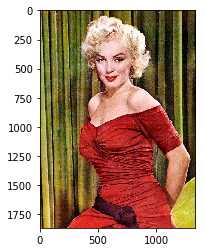

In [4]:
content_image = scipy.misc.imread(CONTENT_IMAGE)
imshow(content_image)

The shape of the target is:  (1865, 1335, 3)
The shape of the style image is:  (1865, 1335, 3)


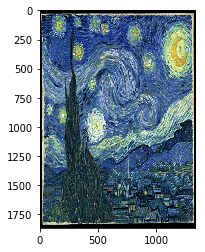

In [5]:
style_image = scipy.misc.imread(STYLE_IMAGE)
target_shape = content_image.shape
style_image = scipy.misc.imresize(style_image, target_shape)
scipy.misc.imsave(STYLE_IMAGE, style_image)
imshow(style_image)
print('The shape of the target is: ', target_shape)
print('The shape of the style image is: ', style_image.shape)

## VGG19 Architecture 

<br>
<br>
<center>![](vgg19arch.png)</center>
*<p style="text-align:right">Image courtesy of (and adapted from) Simonyan and Zisserman - https://arxiv.org/pdf/1409.1556.pdf
</p>*

In [ ]:
def load_vgg_model(path, image_height, image_width, color_channel):
    vgg = scipy.io.loadmat(path)
    vgg_layers = vgg['layers']
    
    def _weights(layer, expected_layer_name):
        W = vgg_layers[0][layer][0][0][0][0]
        b = vgg_layers[0][layer][0][0][0][1]
        layer_name = vgg_layers[0][layer][0][0][-2]
        assert layer_name == expected_layer_name
        return W,b
    
    def _relu(conv2d_layer):
        return tf.nn.relu(conv2d_layer)
    
    def _conv2d(prev_layer, layer, layer_name):
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b,(b.size)))
        return tf.nn.conv2d(prev_layer,filter=W, strides=[1,1,1,1], padding='SAME')+b
    
    def _conv2d_relu(prev_layer, layer, layer_name):
        return _relu(_conv2d(prev_layer, layer, layer_name))
    
    def _avgpool(prev_layer):
        return tf.nn.avg_pool(prev_layer, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
    graph = {}
    graph['input'] = tf.Variable(np.zeros((1,image_height,image_width,color_channel)), dtype='float32')
    graph['conv1_1'] = _conv2d_relu(graph['input'],0,'conv1_1')
    graph['conv1_2'] = _conv2d_relu(graph['conv1_1'],2,'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    return graph